In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg
from scipy.stats import zscore
import seaborn as sns

from biosfa.data import timeseries
from biosfa.util import pltx
from biosfa.models.quadsfa import QuadSFA

inv = np.linalg.inv
norm = np.linalg.norm
sqrtm = scipy.linalg.sqrtm

### Parameters

In [2]:
# time domain length
T = 10**6
# window size
m = 4
# monomial expansion order
order = 2

### Generate time series

In [3]:
# driving force: this is what we want to recover
driving = timeseries.sum_sines(T=(T + m - 1)) / 1.25
# slow feature drives a chaotic iterated map
series = timeseries.logisticmap(driving)
# save files
np.save("driving.npy",driving)
np.save("series.npy",series)

In [4]:
# this is what we want to recover
true_s_plot = zscore(driving[-5000 - m + 1:-m + 1])
# fix sign ambiguity
true_s_plot *= np.sign(true_s_plot[0])

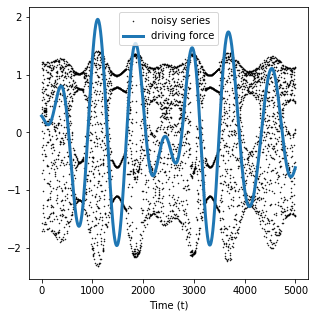

In [5]:
plt.figure(figsize=(5,5))
# zscore to plot everyone togethera
plt.plot(zscore(series[-5000:]), "k.", ms=1.0, label="noisy series")
plt.plot(true_s_plot, lw=3, label="driving force")
plt.xlabel("Time (t)")
# plt.xticks([])
# plt.yticks([])
plt.legend()
plt.savefig("raw_series.png", dpi=300, transparent='true', bbox_inches='tight')

### Define the m-dimensional signal s

In [6]:
signal = np.array([series[i : i + m] for i in range(T)])
signal = signal - np.mean(signal, axis=0)
signal = signal@inv(sqrtm(np.cov(signal.T)))

### Define the quadratic expansion

In [7]:
k = np.int(m+m*(m+1)/2)

X = np.zeros((k,T))

X[0:m,:] = signal.T

for t in range(T):
    X[m,t] = signal[t,0]*signal[t,0]
    X[m+1,t] = signal[t,1]*signal[t,0]
    X[m+2,t] = signal[t,1]*signal[t,1]
    X[m+3,t] = signal[t,2]*signal[t,0]
    X[m+4,t] = signal[t,2]*signal[t,1]
    X[m+5,t] = signal[t,2]*signal[t,2]
    X[m+6,t] = signal[t,3]*signal[t,0]
    X[m+7,t] = signal[t,3]*signal[t,1]
    X[m+8,t] = signal[t,3]*signal[t,2]
    X[m+9,t] = signal[t,3]*signal[t,3]
    
np.save("X", X)

### Define the running 2-step sum and difference

In [8]:
X_bar = X[:,0:T-1] + X[:,1:T]
X_dot = X[:,1:T] - X[:,0:T-1]

### GEVP solution

In [9]:
Cxx = np.cov(X)
Cxx_bar = np.cov(X_bar)
Cxx_dot = np.cov(X_dot)
Rxx = sqrtm(Cxx)

In [10]:
evals_bar, evecs_bar = scipy.linalg.eigh(Cxx_bar, Cxx)
evals_dot, evecs_dot = scipy.linalg.eigh(Cxx_dot, Cxx)

In [11]:
slow_gevp = evecs_dot[:,0]@X

np.save("gevp_solution", slow_gevp)

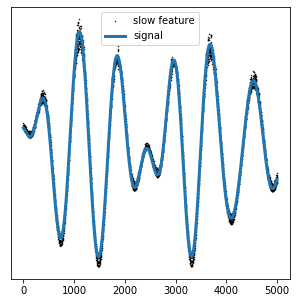

In [12]:
plt.figure(figsize=(5, 5))
# zscore to plot everyone together
plt.plot(zscore(slow_gevp[-5000:]*-1), "k.", ms=1.0, label="slow feature")
plt.plot(true_s_plot, lw=3, label="signal")
plt.yticks([])
# plt.title("GEVP solution")
plt.legend()
plt.savefig("gevp_solution.png", dpi=300, transparent='true', bbox_inches='tight')

### Offline SFA algorithm

Parameters

In [13]:
iters = 10**6; step = .1

Initialization

In [14]:
W = np.random.randn(1,k); W = W/norm(W)
M = 1

In [15]:
off_error = np.zeros(iters)
off_slowness = np.zeros(iters)

Offline algorithm

In [17]:
runtime = np.zeros((iters))
start_time = time.time()

for t in range(iters):
    dW = W@Cxx_bar/M - W@Cxx
    dM = (W@Cxx_bar@W.T)/(M**2) - M
    W = W + step*dW
    M = M + step*dM
    V = W/M
    V = V/norm(V@Rxx)
    off_slowness[t] = V@Cxx_dot@V.T
    off_error[t] = evals_dot[0] - off_slowness[t]
    runtime[t] = time.time() - start_time

Plot slowest projection

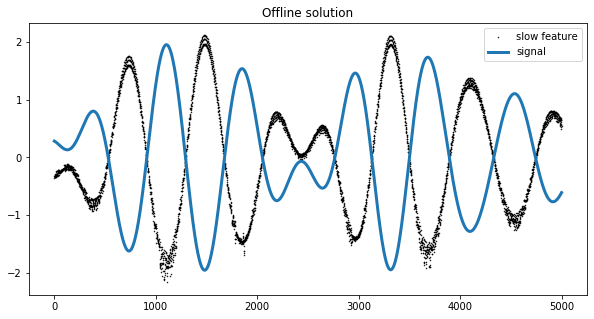

In [18]:
slow_off = W@X/M

np.save("offline_slow.npy", slow_off)

plt.figure(figsize=(10, 5))
# zscore to plot everyone together
plt.plot(zscore(slow_off[0,-5000:]), "k.", ms=1.0, label="slow feature")
plt.plot(true_s_plot, lw=3, label="signal")
plt.title("Offline solution")
plt.legend()
plt.savefig("offline_solution.png")

Min slowness

In [19]:
min_slowness = np.array([evals_dot[0] for i in range(iters)])

In [20]:
min_slowness.shape

(1000000,)

Error plot

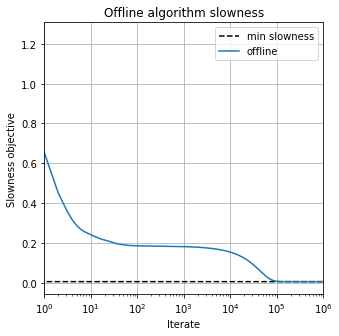

In [21]:
plt.figure(figsize=(5,5))
plt.semilogx(min_slowness, 'k--', label="min slowness")
plt.semilogx(off_slowness, label="offline")
plt.xlabel("Iterate")
plt.ylabel("Slowness objective")
plt.title("Offline algorithm slowness")
plt.grid()
plt.xlim(1,iters)
plt.legend(loc="upper right")
plt.show()